In [1]:
import os
import glob
import json
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from modules import Darknet
from coco import (
    load_classes, compute_coco_detections, compute_name_id_mappings,
    map_ids, convert_coco_detections
)
from utils import write_results
from visualize import (
    read_img, resize_aspect, img_to_tensor,
    inv_aspect_transform_results, clamp_results,
    aspect_transform, uniform_color_palette,
    draw_predictions, draw_palette
)

## Compute predictions

In [2]:
coco_val_path = '/media/semyon/Data/Documents/coco/val2017'
coco_val_preds_path = '/media/semyon/Data/Documents/coco/preds_pt'

In [3]:
if not os.path.exists(coco_val_preds_path):
    os.mkdir(coco_val_preds_path)

In [4]:
classes = load_classes('coco.names')
num_classes = len(classes)

In [5]:
CUDA = False

In [6]:
model = Darknet('yolov3.cfg')
model.load_weights('yolov3.weights')
if CUDA:
    model.cuda()
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch

In [7]:
width = model.net_info['width']
height = model.net_info['height']

In [8]:
paths = list(glob.glob(os.path.join(coco_val_path, '*')))

In [9]:
def compute_image_name(img_path):
    img_file_name = os.path.split(img_path)[1]
    img_id = os.path.splitext(img_file_name)[0]
    return img_id

In [10]:
def compute_output_path(img_path, output_dir):
    img_name = compute_image_name(img_path)
    result_file_name = f'{img_name}.pt'
    result_path = os.path.join(output_dir, result_file_name)
    return result_path

In [11]:
for img_path in tqdm(paths):
    img = read_img(img_path)
    img_aspect = resize_aspect(img, width, height)
    inp = img_to_tensor(img_aspect)
    pred = model(inp, CUDA)
    result = write_results(pred, 0.25, num_classes)
    
    img_file_name = os.path.split(img_path)[1]
    img_name = os.path.splitext(img_file_name)[0]
    result_file_name = f'{img_name}.pt'
    result_path = os.path.join(coco_val_preds_path, result_file_name)
    asp = aspect_transform(img.shape[1], img.shape[0], width, height)
    if len(result) == 0:
        result = torch.tensor([], dtype=torch.float32)
    else:
        result = result[0]
        result = inv_aspect_transform_results(result, asp)
        result = clamp_results(result, img.shape[1], img.shape[0])
    torch.save(result, result_path)

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Check predictions

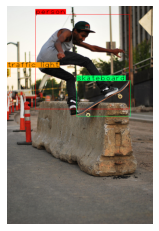

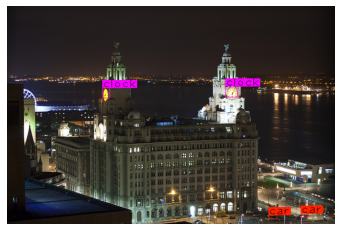

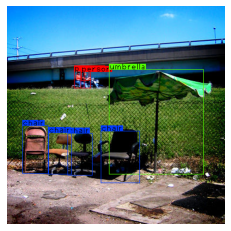

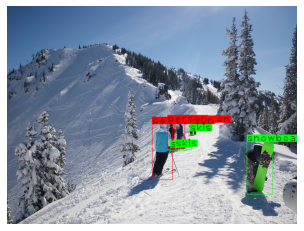

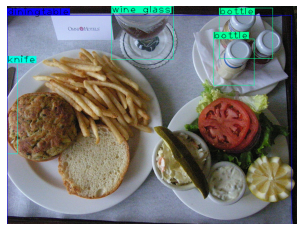

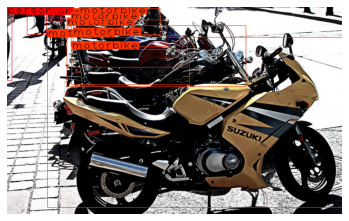

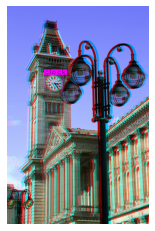

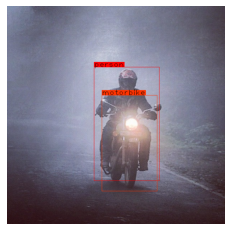

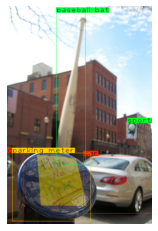

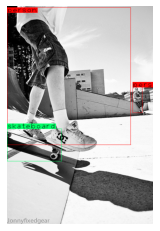

In [11]:
sample = np.random.randint(0, len(paths), size=(10))
palette = uniform_color_palette(num_classes)
permute = np.arange(0, len(palette))
np.random.shuffle(permute)
palette = palette[permute]
for i in sample:
    img_path = paths[i]
    img = read_img(img_path)
    result_path = compute_output_path(img_path, coco_val_preds_path)
    result = torch.load(result_path)
    if result.numel() == 0:
        continue
    output = draw_predictions(img, result, palette, classes)
    plt.imshow(output)
    plt.axis('off')
    plt.show()

In [12]:
count_empty = 0
for img_path in paths:
    result_path = compute_output_path(img_path, coco_val_preds_path)
    result = torch.load(result_path)
    if result.numel() == 0:
        count_empty += 1
print(f'{count_empty}/{len(paths)}')

71/5000


## Coco format

In [13]:
coco_val_detections_path = '/media/semyon/Data/Documents/coco/yolo_dt.json'
annotations_path = '/media/semyon/Data/Documents/coco/annotations/instances_val2017.json'
with open(annotations_path, 'r') as input_file:
    annotations = json.load(input_file)
coco_cat_ids_mapping = '/media/semyon/Data/Documents/coco/coco_cat_ids_mapping.json'
with open(coco_cat_ids_mapping, 'r') as input_file:
    id_mapping = json.load(input_file)
id_mapping = {int(k): v for k, v in id_mapping.items()}

In [14]:
images = annotations['images']
name_id, id_name = compute_name_id_mappings(images)

In [15]:
coco_detections = []
coco_detections_path = os.path.join(coco_val_preds_path)
for img_path in paths:
    file_name = os.path.split(img_path)[1]
    img_id = name_id[file_name]
    result_path = compute_output_path(img_path, coco_val_preds_path)
    result = torch.load(result_path)
    dt = compute_coco_detections(result, img_id)
    coco_detections.extend(dt)
coco_detections = map_ids(coco_detections, id_mapping)
with open(coco_val_detections_path, 'w') as output_file:
    json.dump(coco_detections, output_file)

## ID mapping
val2017 has different category ids

In [16]:
with open('/media/semyon/Data/Documents/coco/categories.json', 'r') as input_file:
    cats = json.load(input_file)

In [17]:
coco_classes = [v['name'] for v in cats.values()]

In [18]:
a = set(classes)
b = set(coco_classes)

In [19]:
a.difference(b)

{'aeroplane', 'diningtable', 'motorbike', 'pottedplant', 'sofa', 'tvmonitor'}

In [20]:
b.difference(a)

{'airplane', 'couch', 'dining table', 'motorcycle', 'potted plant', 'tv'}

In [21]:
map_names = {
    'airplane': 'aeroplane',
    'dining table': 'diningtable',
    'motorcycle': 'motorbike',
    'potted plant': 'pottedplant',
    'tv': 'tvmonitor',
    'couch': 'sofa',
}

In [22]:
my_ids = {c: i + 1  for i, c in enumerate(classes)}
id_mapping = {}
for k, v in cats.items():
    n = v['name']
    if n in map_names:
        n = map_names[n]
    if n in my_ids:
        id_mapping[my_ids[n]] = v['id']

In [23]:
coco_cat_ids_path = '/media/semyon/Data/Documents/coco/coco_cat_ids.json'
coco_cat_ids = list(id_mapping.values())
with open(coco_cat_ids_path, 'w') as output_file:
    json.dump(coco_cat_ids, output_file)

In [24]:
coco_cat_ids_mapping = '/media/semyon/Data/Documents/coco/coco_cat_ids_mapping.json'
with open(coco_cat_ids_mapping, 'w') as output_file:
    json.dump(id_mapping, output_file)

In [25]:
len(id_mapping)

80

## My metrics

In [13]:
from metrics import compute_interpolated_precision

In [23]:
n = 3
m = torch.tensor([1, 0, 1, 0, 0, 0])
tp = (m == 1).cumsum(0)
fp = (m == 0).cumsum(0)
print(tp)
print(fp)
p = tp / (tp + fp)
r = tp / n
t = torch.linspace(0, 1, 101, dtype=torch.float32)
ip = compute_interpolated_precision(p, r, t)
print(ip.mean(0))

tensor([1, 1, 2, 2, 2, 2])
tensor([0, 1, 1, 2, 3, 4])
tensor(0.5545)


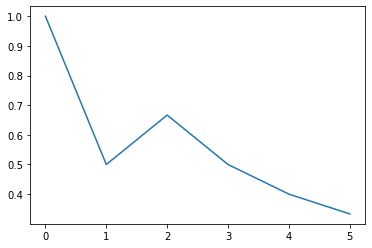

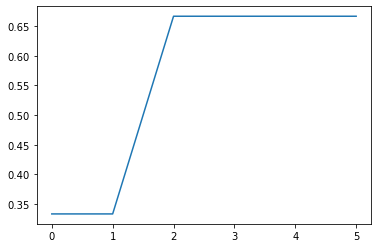

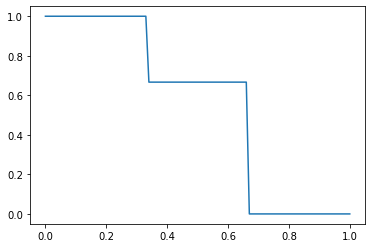

In [24]:
plt.plot(p)
plt.show()
plt.plot(r)
plt.show()
plt.plot(t, ip)
plt.show()

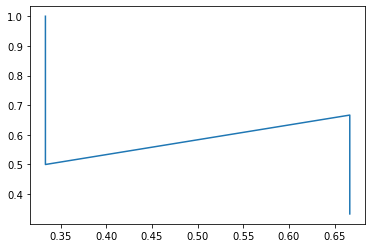

In [16]:
plt.plot(r, p)
plt.show()

In [17]:
annotations_path = '/media/semyon/Data/Documents/coco/annotations/instances_val2017.json'
with open(annotations_path, 'r') as input_file:
    annotations = json.load(input_file)
coco_cat_ids_mapping = '/media/semyon/Data/Documents/coco/coco_cat_ids_mapping.json'
with open(coco_cat_ids_mapping, 'r') as input_file:
    id_mapping = json.load(input_file)
id_mapping = {v: int(k) for k, v in id_mapping.items()}
coco_bboxes = convert_coco_detections(annotations, id_mapping)

In [18]:
for k, v in coco_bboxes.items():
    print(k)
    print(v)

000000289343.jpg
tensor([[4.7307e+02, 3.9593e+02, 3.8650e+01, 2.8670e+01, 1.7000e+01],
        [2.0401e+02, 2.3508e+02, 6.0840e+01, 1.7736e+02, 1.0000e+00],
        [4.3000e-01, 4.9979e+02, 3.3979e+02, 1.0645e+02, 1.4000e+01],
        [2.0442e+02, 3.0410e+02, 5.2510e+01, 1.5276e+02, 2.0000e+00]])
000000061471.jpg
tensor([[272.1000, 200.2300, 151.9700, 279.7700,  17.0000],
        [181.2300,  86.2800,  27.4400,  73.5300,  40.0000],
        [174.7400,   0.0000, 261.0400, 220.7900,  62.0000]])
000000472375.jpg
tensor([[124.7100, 196.1800, 372.8500, 356.8100,  17.0000],
        [ 59.4000,  50.7700, 501.4800, 390.9600,   4.0000],
        [288.8300,  70.0200,  27.5200,  26.7400,  42.0000],
        [312.5900,  76.5200,  27.4400,  23.4200,  42.0000]])
000000520301.jpg
tensor([[112.7100, 154.8200, 367.2900, 479.3500,  17.0000]])
000000579321.jpg
tensor([[200.6100,  89.6500, 400.2200, 251.0200,  17.0000],
        [ 94.7800,   0.9500, 240.6600, 211.0100,   1.0000]])
000000494869.jpg
tensor([[  0.

tensor([[ 88.4500, 168.2700, 377.5300, 149.9300,   6.0000],
        [  2.2900, 224.2100,  29.0100,  58.0100,   1.0000],
        [143.9700, 240.8300,  32.8400,  27.8200,  74.0000],
        [234.6200, 202.0900,  30.0300,  42.4900,  74.0000],
        [303.0400, 193.1300,  36.9500,  49.4300,  74.0000],
        [358.0100, 195.3100,  50.9700,  65.9400,  74.0000],
        [197.2100, 236.3500,  36.5600,  38.7800,  74.0000]])
000000492937.jpg
tensor([[423.5900,  82.5200, 165.0300, 221.4200,   7.0000],
        [355.4000,  24.8600,  97.4300, 316.9800,   1.0000],
        [ 20.6100,  16.0400, 474.0600, 585.0500,   2.0000]])
000000422706.jpg
tensor([[164.6500, 174.3300, 120.7700, 141.1400,   9.0000],
        [  4.8000,  17.2700, 143.9300, 208.2200,   1.0000],
        [  0.0000,   5.7600, 186.1500, 151.6100,   1.0000],
        [  1.4200, 141.1300, 118.9300, 176.2000,   1.0000],
        [252.0400, 266.2300,   9.9200,   8.9600,   1.0000],
        [ 18.5300, 208.0700,  55.6600,  92.1200,  27.0000]])
000

tensor([[288.4100, 419.6500,  84.8100, 187.5400,  62.0000],
        [176.6300, 373.3300,  51.5700,  32.3200,  72.0000]])
000000175387.jpg
tensor([[168.4500, 197.2500, 103.5700, 149.0400,  62.0000]])
000000570736.jpg
tensor([[139.5100, 348.0400, 135.1900, 207.1100,  62.0000],
        [260.3100, 346.6100, 166.6900,  71.9100,  72.0000]])
000000085576.jpg
tensor([[  0.0000, 261.5200, 125.5600, 138.4800,  62.0000]])
000000384850.jpg
tensor([[304.9000, 462.8600, 103.5500, 166.8300,  62.0000]])
000000487583.jpg
tensor([[ 53.7500,  92.9900, 372.2500, 442.2600,  62.0000],
        [342.4300, 165.7200,  68.2200,  77.6500,  42.0000]])
000000201775.jpg
tensor([[235.2100, 227.4800,  77.2600, 119.3200,  62.0000],
        [350.3400, 221.9900,  92.5600, 130.0000,  62.0000],
        [  0.9000, 243.1900, 144.6900,  71.7400,  72.0000]])
000000006818.jpg
tensor([[186.9700, 471.8300, 100.6700,  56.0900,  62.0000]])
000000555012.jpg
tensor([[295.0900,   0.3900, 150.2700, 199.9500,  62.0000]])
000000394328.jp

tensor([[254.2800, 159.2900, 337.7600, 248.5200,   4.0000]])
000000245448.jpg
tensor([[242.6700, 174.0600, 294.0200, 198.4100,   4.0000],
        [477.6500, 181.1400,  53.9000,  37.0700,   4.0000],
        [438.4000, 187.9200,  27.4500,  28.5200,   4.0000],
        [275.2800, 134.4800,  92.4800, 138.7300,   1.0000],
        [157.4800, 115.4200, 126.2100, 305.2500,   1.0000],
        [ 62.4600, 147.0800,  84.1300, 217.4200,   1.0000],
        [235.9900, 154.4800,  25.8300,  62.9100,   1.0000],
        [378.3300, 146.7800,  44.2500,  86.5400,   1.0000],
        [  0.0000, 175.4300, 162.5300,  83.1400,   8.0000],
        [287.2900, 196.4000,  24.0400,  16.9100,   4.0000],
        [613.6000, 179.2200,  26.3000,  34.7800,   4.0000]])
000000455716.jpg
tensor([[  8.7800,   1.4600, 628.0400, 426.1800,   4.0000],
        [  0.0000,  31.1400, 171.2500, 238.3900,   4.0000],
        [426.4000, 167.1600,  96.5300,  62.1300,  25.0000],
        [424.3900, 166.1500, 159.1700,  67.1500,  27.0000]])
000

tensor([[ 41.9500,  38.9100, 234.4700,  97.8700,  10.0000]])
000000088218.jpg
tensor([[212.4500, 278.5600, 103.2900, 182.7900,  10.0000]])
000000155451.jpg
tensor([[526.0000, 305.4800,  30.9300,  19.9700,  10.0000],
        [460.5800,  29.8700,  79.8200, 127.2800,  10.0000],
        [359.8700, 386.8700,  16.2900,  12.0400,   3.0000],
        [557.7300, 329.5100,   9.4000,  11.2300,   3.0000],
        [536.3900, 336.6000,  10.1500,   4.9900,   3.0000],
        [568.6200, 312.1300,  10.1300,  10.5100,  10.0000],
        [453.5600, 333.0400,   5.2800,   5.2000,  10.0000],
        [437.1900, 339.7300,   3.3100,   5.6900,  10.0000],
        [490.6700,   1.1900, 113.7700, 137.4800,  10.0000],
        [504.6800, 315.0100,   9.7900,  10.4400,  10.0000]])
000000412894.jpg
tensor([[302.1200, 338.5200,  61.2300, 135.3800,  10.0000],
        [195.7400, 488.6200,  47.8400, 130.9200,   1.0000],
        [249.2200, 436.0100,  21.8100,  62.4300,   1.0000],
        [268.5100, 428.5400,  15.3800,  49.250

tensor([[  0.0000, 129.6700, 402.7800, 350.3300,  16.0000],
        [236.3500,   1.8300, 403.2400, 470.2500,  64.0000]])
000000387383.jpg
tensor([[ 69.1600, 108.3900, 570.8400, 365.4200,  16.0000],
        [  0.0000, 112.7900, 640.0000, 365.9200,  60.0000]])
000000261706.jpg
tensor([[100.6500,  59.6800, 269.3700, 567.2300,  16.0000],
        [131.0300, 219.5900,  73.2400,  55.0900,  66.0000],
        [  1.4400,   1.4400, 476.0400, 629.9300,  58.0000]])
000000353970.jpg
tensor([[4.3150e+01, 4.6000e-01, 4.3977e+02, 3.8101e+02, 1.6000e+01],
        [0.0000e+00, 0.0000e+00, 6.4000e+02, 4.2142e+02, 5.7000e+01]])
000000108244.jpg
tensor([[182.1200, 157.1800, 354.3400, 194.8200,  16.0000]])
000000278463.jpg
tensor([[124.8300, 239.3700, 100.7500,  96.6500,  16.0000],
        [446.8900, 255.3200,  25.9400,  46.3700,  40.0000],
        [  1.0700, 213.8000,  65.5100, 187.9100,  59.0000],
        [439.0300, 311.0800,  35.9500,  26.8000,  68.0000],
        [216.1200, 223.4300, 151.8800, 154.9500,  

000000362682.jpg
tensor([[ 82.8700,  56.8700, 463.5400, 261.6800,   6.0000],
        [420.5100, 139.1300,  28.6400,  49.4700,   1.0000],
        [  1.0500, 122.5500,  82.3000, 101.9300,   8.0000],
        [539.9700, 133.2600, 100.0300, 166.8800,   8.0000],
        [ 42.1100, 143.4700,  20.5100,  28.5000,   1.0000]])
000000415536.jpg
tensor([[258.8800, 173.6600, 122.9600, 143.4600,   6.0000],
        [277.0800, 226.1800,  24.4600,  23.7300,   1.0000]])
000000082846.jpg
tensor([[ 83.8500, 171.2700, 477.5100, 271.9900,   6.0000],
        [ 59.8600, 176.8200,  13.6500,  16.3700,  12.0000],
        [ 47.2400, 184.8600,  18.7400,  21.9400,  12.0000]])
000000128372.jpg
tensor([[  0.0000,  73.8900, 416.4400, 305.1300,   6.0000],
        [379.0200, 202.4700,  67.1700, 178.4700,   1.0000],
        [445.5100, 222.3400,  32.3700,  97.8300,   1.0000],
        [538.2300, 208.6400,  40.5300, 127.7500,   1.0000],
        [594.8200, 229.6200,  15.8900,  53.0300,   1.0000],
        [611.1500, 224.9400, 

tensor([[509.5900, 252.2400, 129.2800, 173.2300,   3.0000],
        [  0.9100, 186.5700,  80.6800,  87.6900,   3.0000],
        [ 88.0700,  53.4500, 367.6100, 337.9300,   8.0000],
        [553.5900, 100.1100,  12.7700,  32.0800,  10.0000],
        [158.0800,  42.4800,  23.7000,  34.4400,  10.0000],
        [613.6100, 162.9200,  26.3900,  57.5600,   1.0000],
        [582.3600, 169.6300,  12.1800,  22.3600,   1.0000],
        [539.3500, 169.7600,  14.6900,  35.9100,   1.0000],
        [591.7300, 165.6300,   8.3700,  43.0800,   1.0000],
        [628.3300, 164.1900,   7.4600,  16.4900,   1.0000],
        [568.8500, 164.4000,   3.7500,  15.0300,   1.0000],
        [  0.0000, 143.3900,  91.1200,  57.5100,   6.0000],
        [550.3500, 138.8900,  13.1400,  12.8500,  10.0000],
        [554.3500, 167.1400,  15.2800,  45.3800,   1.0000],
        [612.7300, 160.0300,  12.4500,  51.9500,   1.0000],
        [600.0000, 161.0800,  14.7200,  32.0200,   3.0000],
        [474.6700,  81.0400,   7.3500,  

tensor([[ 96.3400, 221.5900, 232.6100, 268.3900,  16.0000],
        [ 64.7200, 267.2700, 293.3900, 277.5700,  72.0000]])
000000287649.jpg
tensor([[1.3664e+02, 4.3000e+00, 5.0336e+02, 3.9765e+02, 1.6000e+01],
        [1.0800e+00, 3.9622e+02, 6.3892e+02, 8.3780e+01, 6.7000e+01],
        [4.6844e+02, 4.2000e-01, 1.7156e+02, 6.5650e+01, 7.4000e+01]])
000000491757.jpg
tensor([[316.2300, 154.6800, 237.8600, 210.6800,  16.0000],
        [  1.0800,   8.6100, 638.9200, 465.0100,  60.0000]])
000000364297.jpg
tensor([[ 22.1400,  91.7300, 612.4800, 313.6200,  16.0000],
        [  0.9600, 262.5700, 404.9200, 158.7000,  67.0000],
        [  1.9200,   1.7600, 335.6700, 216.4100,  63.0000]])
000000080949.jpg
tensor([[ 26.3700, 129.9900, 599.0800, 235.4800,  16.0000],
        [  3.9200,   2.0500, 635.9300, 406.6500,  64.0000],
        [549.5900,   0.0000,  87.1800, 171.8600,  40.0000],
        [527.8200,   0.0000,  44.7500,  72.9800,  42.0000]])
000000115885.jpg
tensor([[345.1600,   3.2300, 154.8400, 2

tensor([[584.7600, 220.6600,  44.8000,  24.9500,  28.0000],
        [189.8400, 306.3400, 264.2700, 168.2700,   1.0000],
        [492.9100,  84.9700, 147.0900, 380.9900,   1.0000],
        [179.8700, 231.1000,  55.5700,  17.8500,  28.0000],
        [ 65.8400,  98.1600, 252.4000, 381.8400,   1.0000]])
000000206025.jpg
tensor([[167.0600, 373.4800,  85.1400, 266.5200,  28.0000],
        [  4.3300,  79.1000, 419.6700, 550.4300,   1.0000]])
000000119641.jpg
tensor([[160.4200, 362.2400,   5.6200,   8.7900,  28.0000],
        [256.8200, 342.0700,  20.0300,  44.7200,   1.0000],
        [148.5600, 349.6000,  28.2600,  54.6900,   1.0000],
        [275.9900, 343.5900,  26.3100,  49.7200,   1.0000],
        [514.6500, 356.7700,  18.9300,  25.9200,   1.0000],
        [128.2400, 353.3400,  24.5600,  25.9000,   1.0000],
        [501.9200, 365.7400,  16.7200,  32.3600,   1.0000],
        [118.0300, 394.5300,  65.9100,  77.9900,  21.0000],
        [248.6500, 389.7300,  54.0500,  68.1100,  21.0000],
    

tensor([[1.9400e+00, 1.6746e+02, 2.4145e+02, 3.0546e+02, 1.7000e+01],
        [2.3157e+02, 1.1000e-01, 4.0843e+02, 4.7989e+02, 7.0000e+01]])
000000364636.jpg
tensor([[118.4400,  88.2900, 520.0800, 439.3300,  17.0000],
        [335.8100,   7.3100, 304.1900, 133.8500,  14.0000]])
000000072813.jpg
tensor([[228.8000, 133.6500, 267.8200, 187.0000,  17.0000],
        [ 53.9300,  30.2000, 154.2500, 142.3800,  63.0000],
        [  0.0000, 145.0700, 640.0000, 329.6600,  60.0000]])
000000283412.jpg
tensor([[  1.7300,   2.4400, 439.0700, 415.6900,  17.0000],
        [  0.0000, 283.8400, 133.7000, 143.1600,  42.0000],
        [427.0000,  99.8200, 210.7300, 163.0300,  60.0000]])
000000367195.jpg
tensor([[130.7400,  64.4600, 181.1600, 125.1500,  17.0000],
        [295.6300,   4.0700, 203.6300, 158.7000,  58.0000],
        [  0.0000,  66.8900,  90.9000,  70.8800,   1.0000]])
000000357459.jpg
tensor([[268.0600,  98.8900, 198.4600, 287.8100,  17.0000],
        [  0.9600, 146.8100, 170.8000, 180.4000,  

tensor([[308.8100, 132.1000, 163.8300, 226.1700,   1.0000],
        [352.1600, 323.4500,  92.5600,  79.5600,  31.0000],
        [387.2500, 336.7700,  50.8100,  33.2800,  31.0000]])
000000197388.jpg
tensor([[1.3941e+02, 1.0225e+02, 2.2239e+02, 2.4157e+02, 1.0000e+00],
        [2.8717e+02, 6.1520e+01, 7.4880e+01, 1.6561e+02, 1.0000e+00],
        [5.4004e+02, 4.8810e+01, 9.9960e+01, 2.2336e+02, 1.0000e+00],
        [3.7258e+02, 1.7084e+02, 2.6663e+02, 2.1719e+02, 1.0000e+00],
        [5.0000e-01, 4.3740e+01, 9.0100e+01, 2.2009e+02, 1.0000e+00],
        [2.6767e+02, 2.1895e+02, 1.2626e+02, 2.1610e+01, 3.1000e+01],
        [1.4182e+02, 2.7087e+02, 4.9730e+02, 5.7710e+01, 3.1000e+01],
        [2.3423e+02, 3.3002e+02, 1.6283e+02, 2.9260e+01, 3.1000e+01],
        [0.0000e+00, 2.5908e+02, 1.0663e+02, 3.6680e+01, 3.1000e+01]])
000000485480.jpg
tensor([[ 66.4500, 114.5500, 143.6700, 144.9300,   1.0000],
        [  0.0000,  90.2300,  88.8600, 161.5400,   1.0000],
        [367.5100,  93.1400,  54.6

tensor([[139.1100, 275.7700, 408.7700, 215.9800,  46.0000],
        [ 58.4400,  45.7800, 416.3800, 281.2400,  46.0000],
        [372.8400, 277.2800, 104.8000, 129.8800,  51.0000],
        [141.6900, 139.5300, 111.2800, 101.2800,  52.0000],
        [  1.4100,   0.7100, 638.5900, 533.1000,  61.0000],
        [150.6800, 202.4600, 227.9500, 139.6800,  48.0000]])
000000296634.jpg
tensor([[234.1300,  41.4300, 373.6000, 377.6700,  46.0000],
        [ 44.8900,  40.8100, 179.5700, 177.5300,  46.0000],
        [ 40.7200, 224.9700, 185.2700, 181.2000,  46.0000],
        [ 57.9300, 305.6800,  44.5400,  42.8500,  52.0000],
        [182.6500, 378.4300,  35.9600,   7.7300,  52.0000],
        [152.1200, 360.7700,  62.1300,   4.9600,  52.0000],
        [ 49.6600, 256.4900,  13.1700,  40.5400,  52.0000],
        [ 93.5200, 358.6300,  49.5000,   8.9100,  52.0000],
        [ 64.5000, 320.0100,  13.2000,  33.9600,  52.0000],
        [ 54.3300,  45.4300, 162.1600, 165.7200,  51.0000],
        [115.1800, 234

tensor([[ 81.2000, 170.7300,  68.2600,  51.9900,  33.0000],
        [111.5600,  37.0300, 150.0300, 389.9700,   1.0000],
        [226.4500,  23.0300, 223.5800, 403.9700,   1.0000],
        [211.0900,  30.6000, 115.6700, 390.3800,   1.0000],
        [ 19.1900,  16.3100, 129.5400, 405.8900,   1.0000],
        [529.8800,   6.6400, 110.1200, 413.7200,   1.0000]])
000000457559.jpg
tensor([[218.3400, 341.2100,  45.5300,  45.1500,  33.0000],
        [ 99.7900,  55.3600, 250.4500, 332.0100,   1.0000],
        [363.3000,  48.6000, 144.5300, 331.0800,   1.0000],
        [539.2700,  43.9800, 100.7300, 284.0300,   1.0000],
        [345.3400,  94.1900,  57.5700,  76.2700,   1.0000],
        [407.8500,  78.3400,  27.3600,  46.0500,   1.0000],
        [575.1200,  46.0500,  64.5800, 212.0200,   1.0000]])
000000188296.jpg
tensor([[287.2100,  36.8200,  35.3900,  33.4800,  33.0000],
        [  1.3700, 288.5300, 117.6900,  99.9100,   3.0000],
        [368.6700, 259.7000,  32.4100,  30.6000,   3.0000],
    

tensor([[126.0900, 260.0400, 236.4800, 257.3500,   1.0000],
        [ 89.2200, 507.0800, 136.2500,  36.8400,  31.0000]])
000000097278.jpg
tensor([[ 84.8600,  77.4300, 245.4700, 499.1100,   1.0000],
        [  0.0000, 542.2400, 399.8000,  51.2400,  32.0000]])
000000068628.jpg
tensor([[238.5800,   0.7700, 252.2300, 221.2200,   1.0000],
        [283.2000, 194.4000, 113.5300, 110.3500,  37.0000]])
000000455448.jpg
tensor([[  0.0000, 160.7800, 356.8000, 478.5300,   1.0000],
        [ 53.2100,  86.0500, 407.0100, 369.6200,  56.0000],
        [234.9500,   2.1600, 243.0500, 582.3400,   1.0000]])
000000465836.jpg
tensor([[152.5300, 126.4600,  65.7300, 192.1400,   1.0000],
        [263.7600, 123.8800,  63.2100, 187.9200,   1.0000],
        [215.4300, 122.9800,  57.4300, 185.9100,   1.0000],
        [213.7300, 305.5700,  57.6400,  40.5000,  31.0000],
        [158.5100, 313.3000,  47.3700,  40.2300,  31.0000],
        [272.8800, 287.6700, 100.2800,  62.9200,  31.0000],
        [277.1400, 154.4100,

tensor([[110.9800, 393.4000,  16.6500,  46.6000,  40.0000],
        [569.0300, 299.6300,  15.3000,  21.6800,  40.0000],
        [  1.0300, 300.3900, 337.5500, 173.4200,  58.0000],
        [444.9000, 262.1900, 195.1000, 157.9400,  58.0000],
        [119.4900, 102.5400, 183.2800, 376.3500,   1.0000],
        [348.8500, 132.5100, 166.3000, 347.4900,   1.0000],
        [569.1900, 318.1100,  18.2500,  25.1900,  42.0000],
        [281.9500, 331.8400,  38.2700,  34.7000,  64.0000],
        [ 69.2200, 369.5500,  95.6100,  58.8700,  64.0000],
        [184.4700, 167.4700,  26.3400,  69.3100,  66.0000],
        [492.7100, 171.6700,  11.8700,  34.8700,  66.0000],
        [139.1300, 417.1200,  33.7600,  15.6500,  66.0000],
        [ 65.6900, 417.1800,  25.4900,  15.3900,  66.0000],
        [322.7200, 271.4900,  15.9100,   4.6600,  74.0000],
        [299.7000, 247.2000,   5.3900,  15.2400,  74.0000],
        [239.4700, 176.4000,  10.1100,  17.9000,  66.0000],
        [319.2800, 310.7300,   4.0800,  

tensor([[  0.0000, 107.3000, 638.1300, 246.8600,  61.0000],
        [170.9900,   0.0000, 469.0100, 140.4900,   1.0000],
        [563.4500, 111.0800,  76.5500, 151.3300,  42.0000],
        [584.8900, 146.8300,  55.1100, 207.3300,  42.0000],
        [461.3600, 140.5500, 111.3000,  34.0400,  43.0000],
        [416.2800, 137.7100,  69.3800,   6.4500,  44.0000],
        [ 96.8100,  87.1300, 411.4400, 225.0800,  54.0000]])
000000074733.jpg
tensor([[1.3800e+00, 1.2240e+02, 6.0924e+02, 4.8272e+02, 6.1000e+01],
        [7.6000e-01, 0.0000e+00, 1.6067e+02, 7.4230e+01, 1.0000e+00],
        [5.3624e+02, 1.2324e+02, 7.5760e+01, 1.3502e+02, 4.2000e+01],
        [1.1624e+02, 5.3130e+01, 7.2350e+01, 1.2556e+02, 4.2000e+01],
        [4.8070e+01, 7.0850e+01, 7.8300e+01, 1.3120e+02, 4.2000e+01],
        [0.0000e+00, 8.6170e+01, 5.7460e+01, 1.4952e+02, 4.2000e+01],
        [2.8130e+02, 3.9512e+02, 1.6466e+02, 2.0446e+02, 4.2000e+01],
        [1.0040e+02, 2.5443e+02, 2.5580e+02, 1.4715e+02, 5.4000e+01],
  

tensor([[222.4700,  61.5200, 206.4600, 136.5100,  63.0000],
        [ 26.9700, 140.7300, 170.2200, 136.5200,  64.0000],
        [452.8400, 258.3900,  35.3300,  28.7900,  65.0000],
        [220.6400, 228.2700, 202.1800,  52.8500,  67.0000],
        [ 51.3600, 221.8700, 118.1300,  31.0500,  67.0000]])
000000366225.jpg
tensor([[ 69.7200,   7.9900, 383.2400, 311.2900,  63.0000],
        [ 50.8500, 249.7500,  44.9100,  72.9400,  68.0000],
        [464.5400, 559.2200,  60.4000,  70.4700,  65.0000],
        [ 85.0500, 523.9600, 354.5900,  80.7200,  67.0000]])
000000549674.jpg
tensor([[ 34.4400,  31.2100, 280.9000, 237.8500,  63.0000],
        [325.6100,   8.6100, 296.9100, 329.0700,  63.0000],
        [198.0400, 310.8000,  40.1800,  44.5000,  68.0000],
        [482.4500, 337.1700,  55.3000,  58.8400,  65.0000],
        [ 57.4100, 346.9900, 402.7300, 111.0400,  67.0000],
        [317.5100, 263.7600,  64.0100,  79.1100,  42.0000]])
000000366141.jpg
tensor([[424.5800, 177.1500, 123.7100,  75.220

tensor([[185.3200,  35.8400, 157.3500, 348.7900,   1.0000],
        [405.8100, 117.5300,  65.3900, 217.9500,   1.0000],
        [304.4400,  84.7000, 154.9600,  39.8000,  35.0000],
        [402.7500, 228.8700,  21.3700,  24.9900,  36.0000]])
000000221291.jpg
tensor([[163.9300, 292.7700,  80.4700, 207.2300,   1.0000],
        [176.0000, 101.7100,  27.9900,  49.2800,  34.0000]])
000000209753.jpg
tensor([[ 41.5200,  64.5700, 383.7100, 565.5500,   1.0000],
        [362.3000, 345.7200, 102.6400, 113.6200,  63.0000],
        [308.6300, 350.4500,  56.2300,  35.4900,  68.0000]])
000000511647.jpg
tensor([[  0.0000,   0.0000, 276.7600, 480.0000,   1.0000],
        [322.2500,  69.5700,  12.9900,  15.1200,  34.0000]])
000000288430.jpg
tensor([[ 89.0000, 180.2900,  37.3000,  86.6900,   1.0000],
        [ 89.3000, 149.6500,   9.8000,  25.5100,   1.0000],
        [ 47.1300, 147.7000,  10.7200,  28.8600,   1.0000],
        [155.4100, 132.2000, 139.3900,  70.0800,  34.0000],
        [438.7100, 132.3000,

tensor([[473.1700, 127.4100,  18.9300,  60.5800,  40.0000],
        [359.2700, 264.1800, 274.3100, 208.8000,  57.0000],
        [ 47.2900, 276.5200, 225.1200, 195.3100,  57.0000],
        [192.9500, 198.6100, 254.6800, 178.1700,  61.0000],
        [340.5100,  81.9000, 271.7600, 321.1800,   1.0000],
        [ 59.0800, 118.2300, 291.1000, 354.4700,   1.0000],
        [360.1600, 203.3600,  19.1000,  44.0100,  41.0000],
        [199.7200, 206.8100,  22.0600,  56.0900,  41.0000],
        [231.3500, 216.5700,  82.7500,  47.6900,  46.0000],
        [275.7800, 203.0600,  17.6000,   9.1300,  50.0000],
        [261.7900, 199.4700,  17.7900,  12.5300,  50.0000],
        [355.4500, 262.2500,  31.2200,  10.2800,  54.0000],
        [319.0600, 258.8200,  36.8800,  13.7400,  54.0000],
        [441.1700, 145.0500,  19.1800,  42.6200,  40.0000],
        [255.2100, 199.0500,  62.1800,  22.6600,  46.0000],
        [263.6000, 248.1000,  49.4200,  16.6000,  43.0000],
        [291.9800, 208.6200,   5.7400,  

tensor([[  0.9600,   1.9200, 510.4800, 420.2800,   1.0000],
        [350.5400, 250.9200,  52.2100,  33.8300,  44.0000],
        [428.9100, 293.3600, 211.0900, 125.1300,  46.0000],
        [462.2300, 238.2200,  68.5000,  89.7000,  42.0000],
        [419.1300, 254.8400, 101.7100, 105.3700,  45.0000],
        [382.5200, 154.5700, 257.4800, 170.1300,  61.0000],
        [109.8000, 200.5600, 143.0700, 221.8200,  68.0000]])
000000567886.jpg
tensor([[  0.0000,  98.6000, 198.0300, 268.8200,   1.0000],
        [  0.0000,   3.8300,  42.4500,  82.3600,  74.0000],
        [ 53.9300,   1.6300,  17.7000,  80.9000,  74.0000],
        [ 67.4200,  42.1300, 150.8400, 134.8400,  78.0000],
        [ 34.8200,   0.7200,  16.6800,  85.0700,  74.0000]])
000000025394.jpg
tensor([[ 41.9900, 133.5100, 245.8500, 418.7900,   1.0000],
        [355.2000, 409.6400,  63.8500, 165.2700,  41.0000],
        [327.3300, 269.9100,  10.5900,  25.3800,  41.0000],
        [213.0200, 372.9700,  43.5200,  57.2600,  40.0000],
    

In [19]:
results = np.full((len(paths), num_classes), -1)

In [20]:
for i, path in enumerate(paths):
    image_name = os.path.split(path)[1]
    pred_path = compute_output_path(path, coco_val_preds_path)
    targets = coco_bboxes[image_name]
    preds = torch.load(pred_path)

KeyError: '000000041488.jpg'

In [21]:
print(len(coco_bboxes))

4952
